In [90]:
import pandas as pd
import numpy as np
import geopandas as gpd 
from modules import preprocess
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# USER INPUTS
ecmwf_country = "BR" # one of ["US", "BR"]
crop = "wheat" # one of ["maize", "wheat"]

shapefile_path, crop_season_in_days_of_year, crop_season_in_months, test_years = preprocess.get_study_metadata(ecmwf_country, crop)

print(crop, ecmwf_country, crop_season_in_days_of_year, crop_season_in_months, test_years)

wheat BR (129, 329) (5, 11) [2006, 2015, 2017]


In [92]:
# CY-BENCH
yield_data = pd.read_csv("../data/CY-Bench/{}/{}/yield_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
yield_data["production [mio. t]"] = yield_data["production"] / 1e6 
yield_data["harvested_area [mio. ha]"] = yield_data["harvested_area"] / 1e6 
crop_calendar = pd.read_csv("../data/CY-Bench/{}/{}/crop_calendar_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
relevant_adm_ids = yield_data["adm_id"].unique()

# Country shapefile
country_gpd = gpd.read_file(shapefile_path)
country_gpd = country_gpd.set_crs("EPSG:4326", allow_override=True) # allow override because US shapefile is already in 4326
country_gpd["adm_id"] = ""
if ecmwf_country == "US":
    country_gpd["adm_id"] = "{}-".format(ecmwf_country) + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
if ecmwf_country == "BR":
    country_gpd["adm_id"] = country_gpd["ADM2_PCODE"]

### Figures

In [93]:
crop_production_harvested_area = yield_data.loc[yield_data["harvest_year"].between(2003,2022)].groupby("adm_id")[["yield", "production", "harvested_area", "production [mio. t]", "harvested_area [mio. ha]"]].mean().reset_index()
adm1_level = country_gpd.dissolve(by="ADM1_PT").to_crs("EPSG:4326").reset_index()[["ADM1_PT", "geometry"]]
country_gpd_crop = country_gpd.loc[country_gpd["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)
adm1_level_crop_calendar = gpd.GeoDataFrame(crop_calendar.merge(country_gpd_crop, on="adm_id")).dissolve(by="ADM1_PT", aggfunc={"sos": "mean", "eos": "mean"}).to_crs("EPSG:4326").reset_index()
adm1_level_crop_production = gpd.GeoDataFrame(crop_production_harvested_area.merge(country_gpd_crop, on="adm_id")).dissolve(by="ADM1_PT", aggfunc={"production": "sum", 
                                                                                                                                                   "harvested_area":"sum",
                                                                                                                                                   "production [mio. t]":"sum",
                                                                                                                                                   "harvested_area [mio. ha]":"sum"}).to_crs("EPSG:4326").reset_index()
adm1_level_crop = gpd.GeoDataFrame(adm1_level_crop_calendar.merge(adm1_level_crop_production.drop("geometry", axis=1), on="ADM1_PT")).to_crs("EPSG:4326").reset_index()

crop_calendar_info_map = gpd.GeoDataFrame(adm1_level.merge(adm1_level_crop[["ADM1_PT", "sos", "eos", "production", "harvested_area", "production [mio. t]", "harvested_area [mio. ha]"]], on="ADM1_PT"))
crop_calendar_info_map = crop_calendar_info_map.assign(length=crop_calendar_info_map["eos"] - crop_calendar_info_map["sos"],
                                                       intensity=crop_calendar_info_map["harvested_area"]/crop_calendar_info_map["geometry"].to_crs(epsg=32723).area)

adm2_crop_data = gpd.GeoDataFrame(crop_production_harvested_area.merge(country_gpd_crop, on="adm_id")).to_crs("EPSG:4326")
adm2_crop_data = adm2_crop_data.assign(intensity=100 * 10000 * adm2_crop_data["harvested_area"]/adm2_crop_data["geometry"].to_crs(epsg=32723).area)

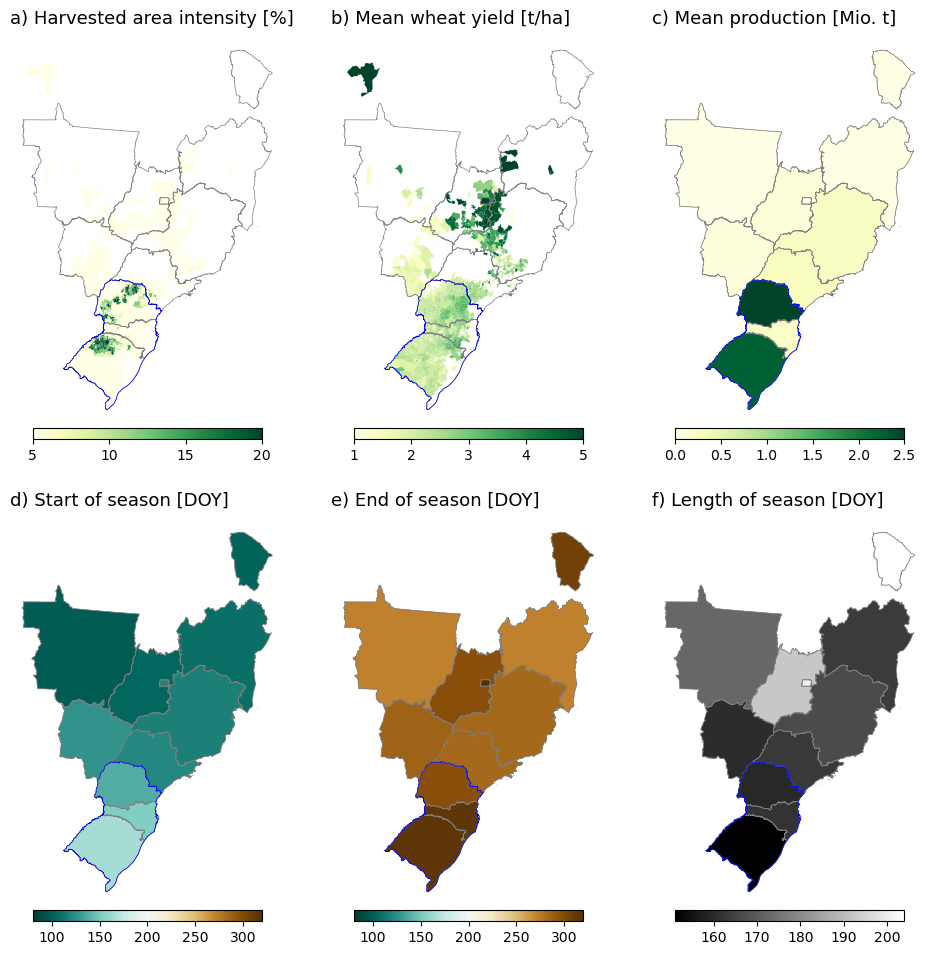

In [94]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.ravel()

# a) Production by adm2
adm2_crop_data.plot(ax=axs[0], column="intensity", vmin=5, vmax=20, legend=True, edgecolor="none", linewidth=0, cmap="YlGn", legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0})
axs[0].set_title("a) Harvested area intensity [%]", loc="left", fontsize=13)

# b) Harvested area by adm2
adm2_crop_data.plot(ax=axs[1], column="yield", legend=True, vmin=1, vmax=5, edgecolor="none", linewidth=0, cmap="YlGn", legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0})
axs[1].set_title("b) Mean wheat yield [t/ha]", loc="left", fontsize=13)

# c) Harvested area intensity by adm1
crop_calendar_info_map.plot(column="production [mio. t]", vmin=0, vmax=2.5, legend=True, edgecolor="black", linewidth=.1, cmap="YlGn", ax=axs[2], legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0})
axs[2].set_title("c) Mean production [Mio. t]", loc="left", fontsize=13)

# d) Start of season by adm1
crop_calendar_info_map.plot(column="sos", legend=True, edgecolor="black", linewidth=.1, vmin=80, vmax=320, cmap="BrBG_r", ax=axs[3], legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0, 'ticks': [100, 150, 200, 250, 300]})
axs[3].set_title("d) Start of season [DOY]", loc="left", fontsize=13)

# e) End of season by adm1
crop_calendar_info_map.plot(column="eos", legend=True, edgecolor="black", linewidth=.1, vmin=80, vmax=320, cmap="BrBG_r", ax=axs[4], legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0, 'ticks': [100, 150, 200, 250, 300]})
axs[4].set_title("e) End of season [DOY]", loc="left", fontsize=13)

# f) Length of season by adm1
crop_calendar_info_map.plot(column="length", legend=True, edgecolor="black", linewidth=.1, ax=axs[5], cmap="gray", legend_kwds={'orientation': 'horizontal', "shrink":.7, 'pad': 0, 'ticks': [160, 170, 180, 190, 200]})
axs[5].set_title("f) Length of season [DOY]", loc="left", fontsize=13)

for ax in axs: 
    crop_calendar_info_map.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=.5)
    crop_calendar_info_map.loc[crop_calendar_info_map["ADM1_PT"].isin(["Rio Grande do Sul", "Paraná", "Santa Catarina"])].dissolve().plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=.5)
    ax.axis("off")

plt.tight_layout()
plt.savefig("season_{}_{}.png".format(crop, ecmwf_country))
plt.show()

In [107]:
adm2_south = adm2_crop_data.loc[adm2_crop_data["ADM1_PT"].isin(["Paraná", "Santa Catarina", "Rio Grande do Sul"]), :].reset_index(drop=True)

In [114]:
yield_south = yield_data.loc[(yield_data["adm_id"].isin(adm2_south.adm_id.unique())) & (yield_data["harvest_year"].between(2003, 2022))].reset_index(drop=True)

In [120]:
yield_south.shape

(15745, 17)

In [127]:
yield_data['adm_id'].value_counts() > 14

adm_id
BR4122503     True
BR4119400     True
BR4123204     True
BR4123105     True
BR4123006     True
             ...  
BR3524808    False
BR3528205    False
BR3530003    False
BR4203956    False
BR1300805    False
Name: count, Length: 1584, dtype: bool

In [132]:
min_count = 14
adm_id_counts = yield_south['adm_id'].value_counts()
valid_adm_ids = adm_id_counts[adm_id_counts >= min_count].index
yield_data_filtered = yield_south[yield_south['adm_id'].isin(valid_adm_ids)]

In [134]:
yield_data_filtered.shape

(14544, 17)

In [141]:
yield_data_filtered

,crop_name,crop_id,country_code,adm_id,adm_name,season_name,planting_year,planting_date,harvest_year,harvest_date,source,yield,production,harvested_area,planted_area,production [mio. t],harvested_area [mio. ha]
0,Wheat,0.0,BRA,BR4100103,Abatiá (PR),0.0,2003,2003-05,2003,2003-12,https://sidra.ibge.gov.br/tabela/1612,2.300,11500.0,5000.0,5000.0,0.011500,0.00500
1,Wheat,0.0,BRA,BR4100103,Abatiá (PR),0.0,2004,2004-05,2004,2004-12,https://sidra.ibge.gov.br/tabela/1612,2.000,12000.0,6000.0,6000.0,0.012000,0.00600
2,Wheat,0.0,BRA,BR4100103,Abatiá (PR),0.0,2005,2005-05,2005,2005-12,https://sidra.ibge.gov.br/tabela/1612,2.100,10080.0,4800.0,4800.0,0.010080,0.00480
3,Wheat,0.0,BRA,BR4100103,Abatiá (PR),0.0,2006,2006-05,2006,2006-12,https://sidra.ibge.gov.br/tabela/1612,0.479,422.0,880.0,880.0,0.000422,0.00088
4,Wheat,0.0,BRA,BR4100103,Abatiá (PR),0.0,2007,2007-05,2007,2007-12,https://sidra.ibge.gov.br/tabela/1612,2.400,11520.0,4800.0,4800.0,0.011520,0.00480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15729,Wheat,0.0,BRA,BR4323754,Vitória das Missões (RS),0.0,2018,2018-05,2018,2018-12,https://sidra.ibge.gov.br/tabela/1612,2.880,8640.0,3000.0,3000.0,0.008640,0.00300
15730,Wheat,0.0,BRA,BR4323754,Vitória das Missões (RS),0.0,2019,2019-05,2019,2019-12,https://sidra.ibge.gov.br/tabela/1612,3.300,8250.0,2500.0,2500.0,0.008250,0.00250
15731,Wheat,0.0,BRA,BR4323754,Vitória das Missões (RS),0.0,2020,2020-05,2020,2020-12,https://sidra.ibge.gov.br/tabela/1612,2.400,6000.0,2500.0,2500.0,0.006000,0.00250
15732,Wheat,0.0,BRA,BR4323754,Vitória das Missões (RS),0.0,2021,2021-05,2021,2021-12,https://sidra.ibge.gov.br/tabela/1612,2.400,6360.0,2650.0,2650.0,0.006360,0.00265


In [154]:
national_yield = (
    yield_data_filtered.assign(yield_weighted=yield_data_filtered["yield"] * yield_data_filtered["harvested_area"])
    .groupby(["harvest_year"])
    .agg({"harvested_area": "sum", "yield_weighted": "sum"})
    .assign(national_yield=lambda x: x["yield_weighted"] / x["harvested_area"])
    .reset_index()
    [["harvest_year", "harvested_area", "national_yield"]]
)

0.04315342594484639


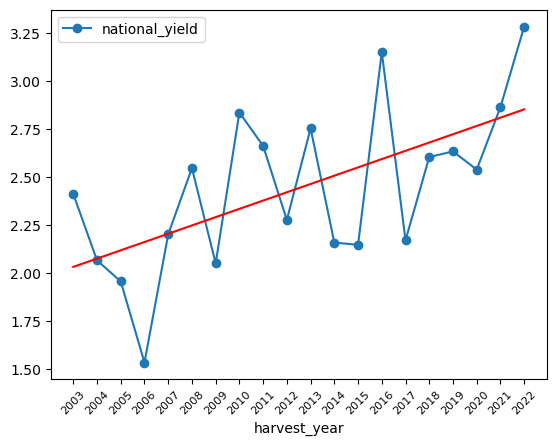

In [162]:
national_yield.plot(x="harvest_year", y="national_yield", marker="o")
slope, bias = np.polyfit(national_yield["harvest_year"], national_yield["national_yield"], 1)
print(slope)
plt.plot(national_yield["harvest_year"], slope * national_yield["harvest_year"] + bias, color="red")
plt.xticks(national_yield["harvest_year"], size=8, rotation=45);

<Axes: ylabel='Frequency'>

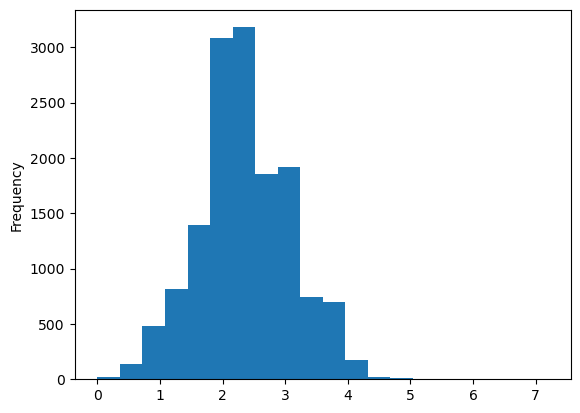

In [137]:
yield_data_filtered["yield"].plot(kind="hist", bins=20)